# The O.G. Transformer

## Run on Colab:

Launch this link to run this on colab [here](https://colab.research.google.com/github/will-thompson-k/deeplearning-nlp-models/blob/master/notebooks/transformer/transformer.ipynb).

## Colab Setup

You can skip this section if not running on Google's colab.

If running with GPUs, sanity check that the GPUs are enabled.

In [ ]:
!nvidia-smi

In [2]:
import torch
torch.cuda.is_available()

True

Ahould be True. If not, debug (Note: version of pytorch I used is not capatible with CUDA drivers on colab. Follow these instructions here explicitly).

In [3]:
!pwd

/content


This should be "/content" on Colab.

First, if running from colab, you must install the package. (You may skip if you installed already).

In [ ]:
!git clone https://github.com/will-thompson-k/deeplearning-nlp-models.git
%cd deeplearning-nlp-models

In [ ]:
! pip install torchtext==0.8.0

In [ ]:
!python setup.py install

## Imports

Here are the packages we need to import.

In [6]:
from nlpmodels.models import transformer
from nlpmodels.utils import train,utils
from nlpmodels.utils.elt import transformer_dataset
from argparse import Namespace
utils.set_seed_everywhere()

## Language Translation: German to English

We will try to train our transformer model to learn how to translate German -> English using the torchtext::Multi30k data.

### Hyper-parameters

These are the data processing and model training hyper-parameters for this run. Note that we are running a smaller model
than cited in the paper for fewer iterations...on a CPU. This is meant merely to demonstrate it works.

In [7]:
args = Namespace(
    # Model hyper-parameters
    num_layers_per_stack = 6, #original value = 6
    dim_model = 512,
    dim_ffn = 2048,
    num_heads = 8,
    max_sequence_length = 20, #original value = 1000
    dropout = 0.1,
    # Label smoothing loss function hyper-parameters
    label_smoothing = 0.1,
    # Training hyper-parameters
    num_epochs=30,
    learning_rate=0.0,
    batch_size = 64,
)

In [8]:
train_dataloader, vocab_source, vocab_target = transformer_dataset.TransformerDataset.get_training_dataloader(args)
vocab_source_size = len(vocab_source)
vocab_target_size = len(vocab_target)
model = transformer.Transformer(vocab_source_size, vocab_target_size,
                                args.num_layers_per_stack, args.dim_model,
                                args.dim_ffn, args.num_heads, args.max_sequence_length,
                                args.dropout)
trainer = train.TransformerTrainer(args, vocab_target_size, vocab_target.mask_index, model, train_dataloader)

In [9]:
trainer.run()


[Epoch 29]: 100%|██████████| 437/437 [01:05<00:00,  6.69it/s, loss=33.4]

Finished Training...


# Attention Plots

Once the model is trained, we can examine the attention plots for self-attention (encoder, decoder) and the encoder-decoder
attention to see if there is structure the model is learning.


Encoder Layer 1


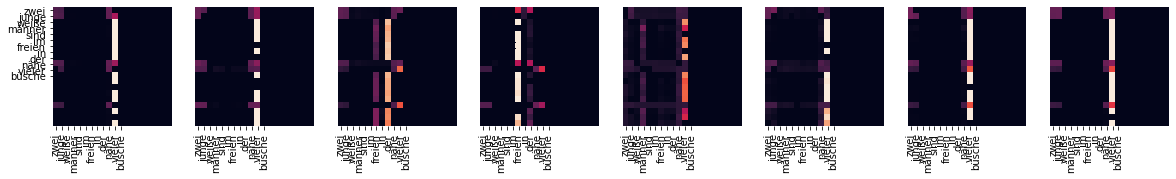

Encoder Layer 2


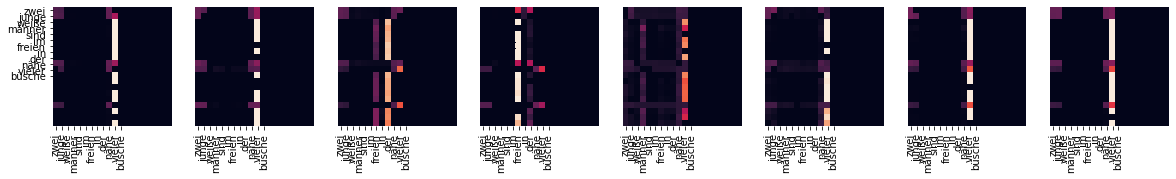

Encoder Layer 3


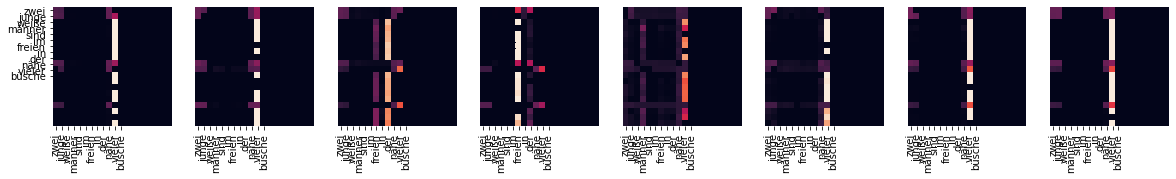

Encoder Layer 4


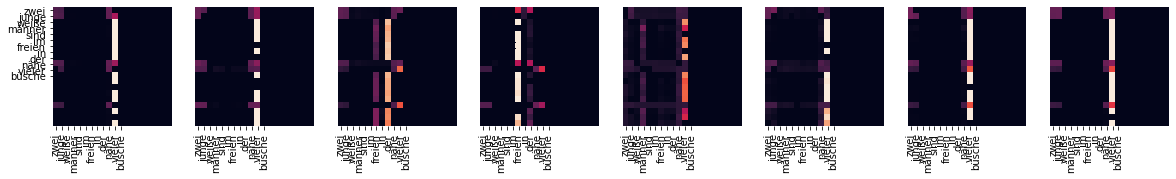

Encoder Layer 5


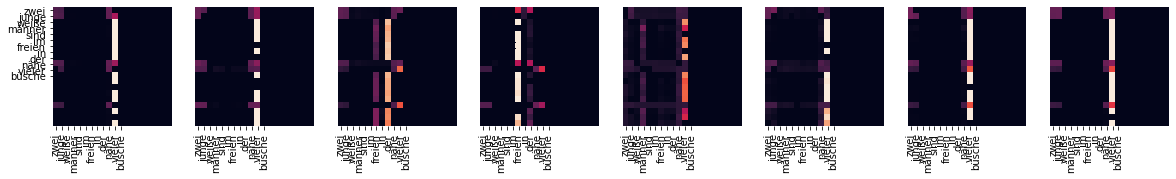

Decoder Self Layer 1


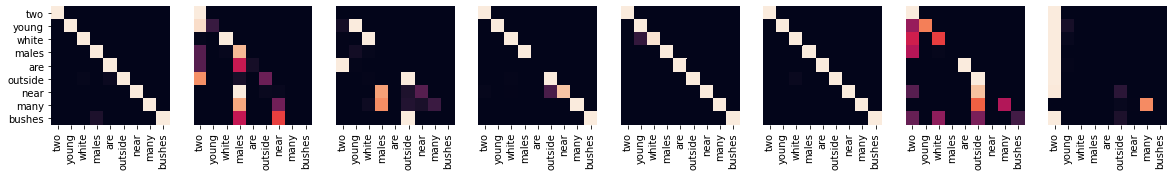

Decoder Src Layer 1


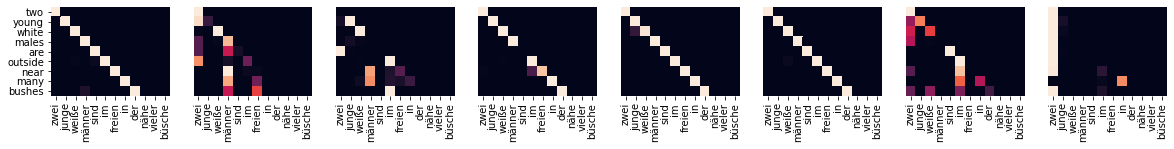

Decoder Self Layer 2


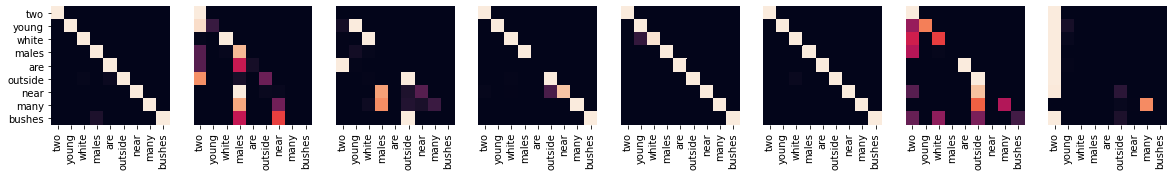

Decoder Src Layer 2


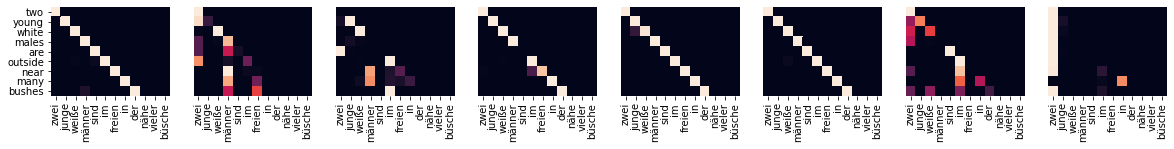

Decoder Self Layer 3


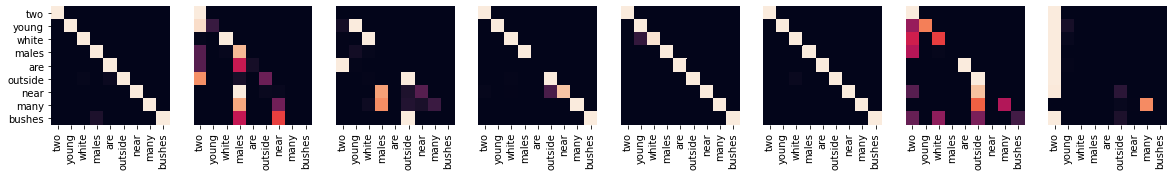

Decoder Src Layer 3


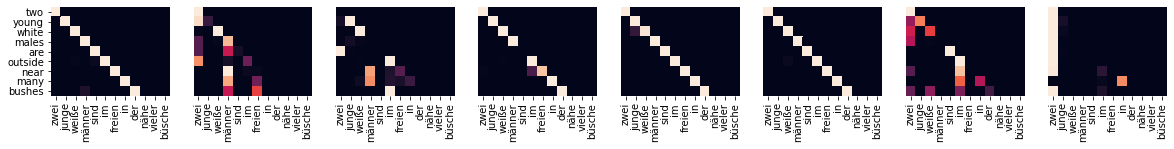

Decoder Self Layer 4


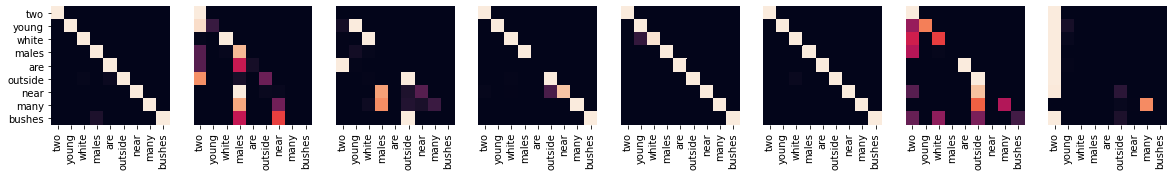

Decoder Src Layer 4


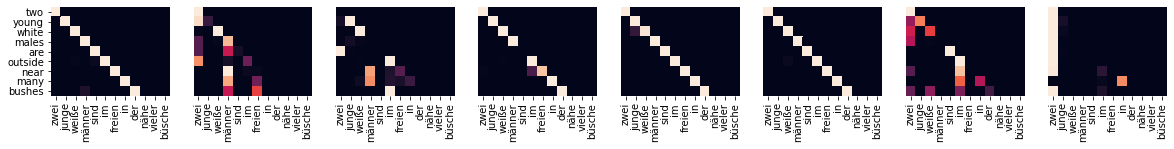

Decoder Self Layer 5


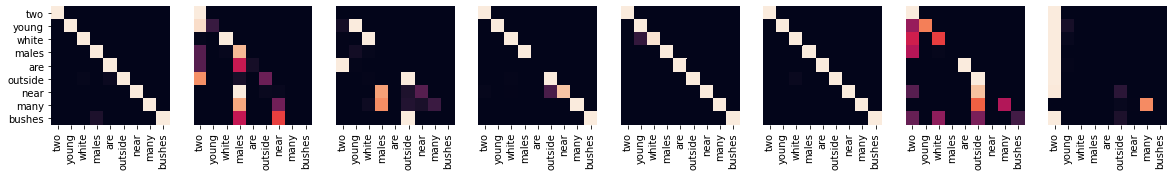

Decoder Src Layer 5


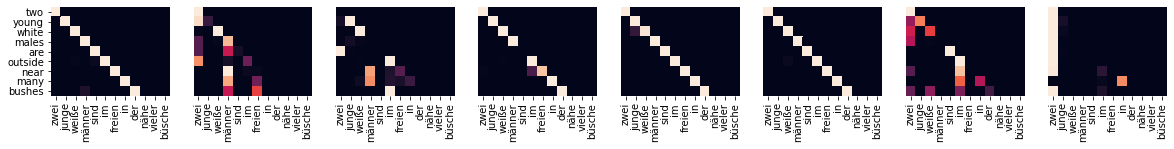

In [12]:
import seaborn
import matplotlib.pyplot as plt
source = ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche']
target = ['two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes']
def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax)

for layer in range(5):
    fig, axs = plt.subplots(1,8, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(8):
        draw(model._encoder_block._layers[layer]._self_attention._attention_tensor[0, h].data.cpu(),
            source, source if h ==0 else [], ax=axs[h])
    plt.show()

for layer in range(5):
    fig, axs = plt.subplots(1,8, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(8):
        draw(model._decoder_block._layers[layer]._self_attention._attention_tensor[0, h].data[:len(target), :len(target)].cpu(),
            target, target if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,8, figsize=(20, 10))
    for h in range(8):
        draw(model._decoder_block._layers[layer]._self_attention._attention_tensor[0, h].data[:len(target), :len(source)].cpu(),
            source, target if h ==0 else [], ax=axs[h])
    plt.show()

As the model picks up on more signal, we would expect more distinct patterns as the attention layers learn the relationship
between different tokens both within a sequence and across encoder-decoder. While the pattern in the encoder self-attention
layers appear noisy, the decoder self-attention and encoder-decoder attention layers appear to have a more discernible pattern.

(Note that I didn't run the code long enough to get a good enough model. I also set num_layers = 2 instead of 6 and ran for 15
epochs on a CPU.)

Attention-based architectures are a very active area of research. Note that one of the drawbacks of this attention mechanism
is that it scales quadratic in time and memory with the size of sequences. As a result, there is research into sparsity-based
attention mechanisms as one potential solution (i.e., Google's Performer model). Refer to the README for a more in-depth
overview of the Transformer models.